In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import json
import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import matplotlib as mpl
import csv
import matplotlib.pyplot as plt

In [5]:
asq_labelDF = pd.read_csv('/content/drive/MyDrive/AIVAS/Pilot Dec 1/pruned_valid_data_41entry_class.csv')
asq_labelDF.head(3)

,idx,PROLIFIC_PID,BlockLink,Finished,AQ SC0,Q13,Q14,Q15,Q34,Class_SelfReported,HA SC0,Total time
0,16,5ba5d8b960f3d50001697104,e19a9948-8ae4-4456-aa0d-e2473c5b2b24,True,30,62,Female,Female,Don't know/Rather not say,0,1023,2213.409932
1,12,5e5214e745774623bd28289f,b03d9deb-4b4b-4172-88be-f1c2f883729d,True,19,25,Male,Male,Don't know/Rather not say,0,420,1216.172043
2,1,5c4684826a7dbc00017c0a87,39574442-cad8-423d-8e50-af77bd02e4be,True,34,23,Male,Gender non-conforming,I am in the process of receiving a diagnosis,1,525,841.159421


In [6]:
feat_labelDF = pd.read_csv('/content/drive/MyDrive/AIVAS/Pilot Dec 1/pruned_valid_41data_feat.csv')
feat_labelDF.head(2)

,idx,PROLIFIC_PID,BlockLink,Finished,AQ SC0,Q13,Q14,Q15,Q34,HA SC0,...,8_block_events_num,8_construction_region_time,8_construction_show_events_num,8_drop_events_num,8_pattern_region_time,8_pattern_show_events_num,8_pickup_events_num,8_rotate_events_num,8_show_events_num,8_time_spent
0,0,5e24870ba6a74070b7de1d5c,70473617-eefd-4ae6-947d-7b356dc147b7,True,20.0,31,Male,Male,No,659.0,...,8,31.033,8,3,7.512,8,3,2,21,48.787
1,1,5c4684826a7dbc00017c0a87,39574442-cad8-423d-8e50-af77bd02e4be,True,34.0,23,Male,Gender non-conforming,I am in the process of receiving a diagnosis,525.0,...,9,19.516,6,2,3.355,6,2,5,14,32.461


In [7]:
feat_labelDF.columns[:30]

Index(['idx', 'PROLIFIC_PID', 'BlockLink', 'Finished', 'AQ SC0', 'Q13', 'Q14',
       'Q15', 'Q34', 'HA SC0', 'Total time', '0_bank_region_time',
       '0_bank_show_events_num', '0_block_events_num',
       '0_construction_region_time', '0_construction_show_events_num',
       '0_drop_events_num', '0_pattern_region_time',
       '0_pattern_show_events_num', '0_pickup_events_num',
       '0_rotate_events_num', '0_show_events_num', '0_time_spent',
       '1_bank_region_time', '1_bank_show_events_num', '1_block_events_num',
       '1_construction_region_time', '1_construction_show_events_num',
       '1_drop_events_num', '1_pattern_region_time'],
      dtype='object')

In [8]:
## returns asd and non-asd PID lists
def getPID_class():
  asq_labelDF = pd.read_csv('/content/drive/MyDrive/AIVAS/Pilot Dec 1/pruned_valid_data_41entry_class.csv')

  asd_df = asq_labelDF[asq_labelDF['Class_SelfReported'] == 1]

  asd_PID = asd_df['PROLIFIC_PID'].to_list()

  print(asd_PID)


  nonasd_df = asq_labelDF[asq_labelDF['Class_SelfReported'] == 0]

  nonasd_PID = nonasd_df['PROLIFIC_PID'].to_list()

  #print(asd_PID)
  return (asd_PID, nonasd_PID)



In [9]:
def scale_sh(age, habit_score):
  '''
  <=25:  score [0-1404]
26-34: score [0-1872]
35-50: score [0-2340]
>=51: score [0-2808]
'''

  if age<=25:
    scale_habit_score = habit_score/1404

  elif (age>25) and (age<=34):
    scale_habit_score = habit_score/1872
  
  elif (age>34) and (age<=50):
    scale_habit_score = habit_score/2340

  else:
    scale_habit_score = habit_score/2808

  return scale_habit_score

In [10]:
asd, non_asd = getPID_class()

['5c4684826a7dbc00017c0a87', '5c4e9bd1818d4d00013e8859', '5783d604900cc80001d2d767', '5a94ca1a873cda0001dc7147', '6104d2792c6a9b50dfbc4239', '578bcb2c09fb91000133750e', '5d1e2045a37a4d001a1fc2cb', '62cf1b74abd9894b74d28a00', '61692abb0f3acf7a49d91533', '62e1bc1f7bc99745a170ce2e', '628c2454c8c66010dd87391d', '55cb79e0fdf99b3c26ae4bca', '5b690c1840003400016fdb4b', '5eb3935fd0e02317909c5f32', '58ae45f35e63bf00013b530e']


In [11]:
def get_scatter_feat(val1, val2, x_val3, BDT_ind):
 # 0_bank_show_events_num', '0_block_events_num',
  #     '0_construction_region_time', '0_construction_show_events_num',
  #     '0_drop_events_num', '0_pattern_region_time',
   #    '0_pattern_show_events_num', '0_pickup_events_num',
   #    '0_rotate_events_num', '0_show_events_num', '0_time_spent',

   ## Total Time = time spent in 9 BDT.
   #ind time spent available

   ## BDT 9
    to_excludePID = ['5ba5d8b960f3d50001697104', '5e5214e745774623bd28289f']

    DATA_PATH =  "/content/drive/MyDrive/AIVAS/Pilot Dec 1/pruned_valid_41data_feat.csv"

    #p1 = mpl.colormaps['Blues']
    csv_file = open(DATA_PATH, "r")
    csv_ = csv.DictReader(csv_file)
    csv_data = list(csv_)

    ## pid label 
    asd, non_asd = getPID_class()

    ## val1 var
    #BDT_ind = 7
    keys_var1 = str(BDT_ind) + val1 #[str(i) + val1 for i in range(9)]

    ### total time. Sometimes denom is 1
    if val2 =='1':
      keys_var2 = 1

    else:
       keys_var2 = str(BDT_ind) + val2 

    ## x val3
    x_var3 = str(BDT_ind) + x_val3 

    x_val = []
    y_val = []
    Label = []

    for row in csv_data:
      #print(row)

      if row['PROLIFIC_PID'] in to_excludePID:
        continue

      if row['PROLIFIC_PID'] in asd:
        Label.append("ASD")
      else:
        Label.append("Non-ASD")

      if val2 =='1':
        y_denom = 1

      else:
        y_denom = float(row[keys_var2])

      

    
      prop_val = float(row[keys_var1])/ y_denom

      x_val_plot = float(row[x_var3])
                       
      y_val.append(prop_val)

      x_val.append(x_val_plot)

      #print("x time ", x_val)
      #print("y actual val ", row[keys_var1])
      #print("y prop val ", y_val)

      df_ = pd.DataFrame(dict(x=x_val, y=y_val, Label=Label))

      groups = df_.groupby('Label')


      #break

    
    return(groups)


In [12]:
BDT_ind = 7
## increase index by 1, as BDT are numbered 0-8
BDT_ind_1 = BDT_ind + 1

In [13]:
def plot_scatter_(groups, xlabel_, ylabel_):

  fig, ax = plt.subplots()
  ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

  for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, Label=name)
  ax.legend(numpoints=1, loc='upper right')

  plt.xlabel(xlabel_, fontsize=15)
  plt.ylabel(ylabel_, fontsize=15)

  plt.show()

In [14]:
groups_df = get_scatter_feat('_pattern_region_time', '_time_spent', '_time_spent', BDT_ind)

['5c4684826a7dbc00017c0a87', '5c4e9bd1818d4d00013e8859', '5783d604900cc80001d2d767', '5a94ca1a873cda0001dc7147', '6104d2792c6a9b50dfbc4239', '578bcb2c09fb91000133750e', '5d1e2045a37a4d001a1fc2cb', '62cf1b74abd9894b74d28a00', '61692abb0f3acf7a49d91533', '62e1bc1f7bc99745a170ce2e', '628c2454c8c66010dd87391d', '55cb79e0fdf99b3c26ae4bca', '5b690c1840003400016fdb4b', '5eb3935fd0e02317909c5f32', '58ae45f35e63bf00013b530e']


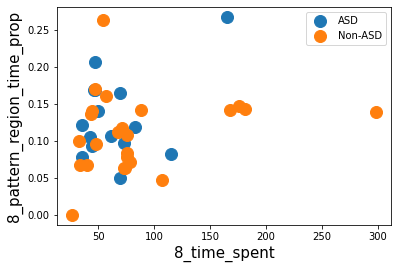

In [15]:
plot_scatter_(groups_df, str(BDT_ind_1)+'_time_spent', str(BDT_ind_1)+'_pattern_region_time_prop',)

['5c4684826a7dbc00017c0a87', '5c4e9bd1818d4d00013e8859', '5783d604900cc80001d2d767', '5a94ca1a873cda0001dc7147', '6104d2792c6a9b50dfbc4239', '578bcb2c09fb91000133750e', '5d1e2045a37a4d001a1fc2cb', '62cf1b74abd9894b74d28a00', '61692abb0f3acf7a49d91533', '62e1bc1f7bc99745a170ce2e', '628c2454c8c66010dd87391d', '55cb79e0fdf99b3c26ae4bca', '5b690c1840003400016fdb4b', '5eb3935fd0e02317909c5f32', '58ae45f35e63bf00013b530e']


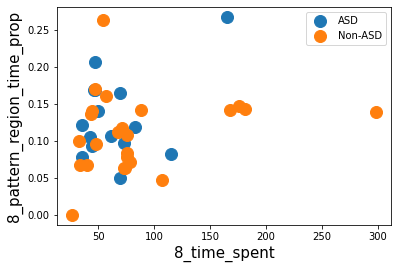

In [16]:
groups_df = get_scatter_feat('_pattern_region_time', '_time_spent', '_time_spent', BDT_ind)
plot_scatter_(groups_df, str(BDT_ind_1)+'_time_spent', str(BDT_ind_1)+'_pattern_region_time_prop',)

['5c4684826a7dbc00017c0a87', '5c4e9bd1818d4d00013e8859', '5783d604900cc80001d2d767', '5a94ca1a873cda0001dc7147', '6104d2792c6a9b50dfbc4239', '578bcb2c09fb91000133750e', '5d1e2045a37a4d001a1fc2cb', '62cf1b74abd9894b74d28a00', '61692abb0f3acf7a49d91533', '62e1bc1f7bc99745a170ce2e', '628c2454c8c66010dd87391d', '55cb79e0fdf99b3c26ae4bca', '5b690c1840003400016fdb4b', '5eb3935fd0e02317909c5f32', '58ae45f35e63bf00013b530e']


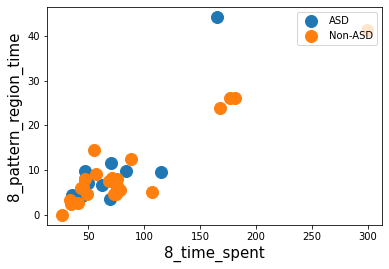

In [17]:
### Raw Pattern Region Time
groups_df = get_scatter_feat('_pattern_region_time', '1', '_time_spent', BDT_ind)
plot_scatter_(groups_df, str(BDT_ind_1)+'_time_spent', str(BDT_ind_1)+'_pattern_region_time',)

['5c4684826a7dbc00017c0a87', '5c4e9bd1818d4d00013e8859', '5783d604900cc80001d2d767', '5a94ca1a873cda0001dc7147', '6104d2792c6a9b50dfbc4239', '578bcb2c09fb91000133750e', '5d1e2045a37a4d001a1fc2cb', '62cf1b74abd9894b74d28a00', '61692abb0f3acf7a49d91533', '62e1bc1f7bc99745a170ce2e', '628c2454c8c66010dd87391d', '55cb79e0fdf99b3c26ae4bca', '5b690c1840003400016fdb4b', '5eb3935fd0e02317909c5f32', '58ae45f35e63bf00013b530e']


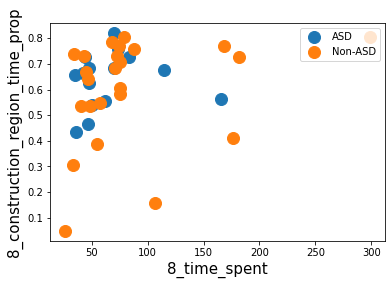

In [18]:
groups_df = get_scatter_feat('_construction_region_time', '_time_spent', '_time_spent', (BDT_ind))
plot_scatter_(groups_df, str(BDT_ind_1)+'_time_spent', str(BDT_ind_1)+'_construction_region_time_prop',)

['5c4684826a7dbc00017c0a87', '5c4e9bd1818d4d00013e8859', '5783d604900cc80001d2d767', '5a94ca1a873cda0001dc7147', '6104d2792c6a9b50dfbc4239', '578bcb2c09fb91000133750e', '5d1e2045a37a4d001a1fc2cb', '62cf1b74abd9894b74d28a00', '61692abb0f3acf7a49d91533', '62e1bc1f7bc99745a170ce2e', '628c2454c8c66010dd87391d', '55cb79e0fdf99b3c26ae4bca', '5b690c1840003400016fdb4b', '5eb3935fd0e02317909c5f32', '58ae45f35e63bf00013b530e']


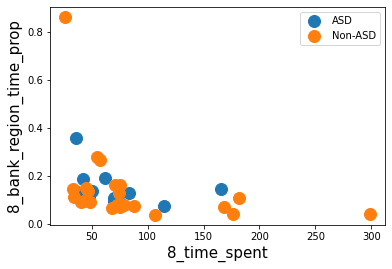

In [19]:
groups_df = get_scatter_feat('_bank_region_time', '_time_spent', '_time_spent', str(BDT_ind))
plot_scatter_(groups_df, str(BDT_ind_1)+'_time_spent', str(BDT_ind_1)+'_bank_region_time_prop',)

['5c4684826a7dbc00017c0a87', '5c4e9bd1818d4d00013e8859', '5783d604900cc80001d2d767', '5a94ca1a873cda0001dc7147', '6104d2792c6a9b50dfbc4239', '578bcb2c09fb91000133750e', '5d1e2045a37a4d001a1fc2cb', '62cf1b74abd9894b74d28a00', '61692abb0f3acf7a49d91533', '62e1bc1f7bc99745a170ce2e', '628c2454c8c66010dd87391d', '55cb79e0fdf99b3c26ae4bca', '5b690c1840003400016fdb4b', '5eb3935fd0e02317909c5f32', '58ae45f35e63bf00013b530e']


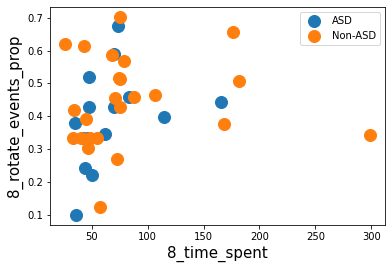

In [20]:
groups_df = get_scatter_feat('_rotate_events_num', '_block_events_num', '_time_spent', str(BDT_ind))
plot_scatter_(groups_df, str(BDT_ind_1)+'_time_spent', str(BDT_ind_1)+'_rotate_events_prop',)

['5c4684826a7dbc00017c0a87', '5c4e9bd1818d4d00013e8859', '5783d604900cc80001d2d767', '5a94ca1a873cda0001dc7147', '6104d2792c6a9b50dfbc4239', '578bcb2c09fb91000133750e', '5d1e2045a37a4d001a1fc2cb', '62cf1b74abd9894b74d28a00', '61692abb0f3acf7a49d91533', '62e1bc1f7bc99745a170ce2e', '628c2454c8c66010dd87391d', '55cb79e0fdf99b3c26ae4bca', '5b690c1840003400016fdb4b', '5eb3935fd0e02317909c5f32', '58ae45f35e63bf00013b530e']


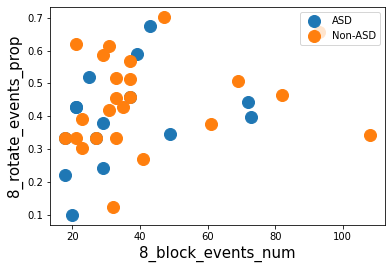

In [21]:
groups_df = get_scatter_feat('_rotate_events_num', '_block_events_num', '_block_events_num', str(BDT_ind))
plot_scatter_(groups_df, str(BDT_ind_1)+'_block_events_num', str(BDT_ind_1)+'_rotate_events_prop',)

['5c4684826a7dbc00017c0a87', '5c4e9bd1818d4d00013e8859', '5783d604900cc80001d2d767', '5a94ca1a873cda0001dc7147', '6104d2792c6a9b50dfbc4239', '578bcb2c09fb91000133750e', '5d1e2045a37a4d001a1fc2cb', '62cf1b74abd9894b74d28a00', '61692abb0f3acf7a49d91533', '62e1bc1f7bc99745a170ce2e', '628c2454c8c66010dd87391d', '55cb79e0fdf99b3c26ae4bca', '5b690c1840003400016fdb4b', '5eb3935fd0e02317909c5f32', '58ae45f35e63bf00013b530e']


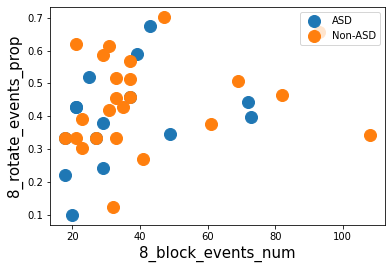

In [22]:
groups_df= get_scatter_feat('_rotate_events_num', '_block_events_num', '_block_events_num', str(BDT_ind))
plot_scatter_(groups_df, '8_block_events_num', '8_rotate_events_prop',)

In [23]:


def box(key, title, fname):
    """Draw box plot"""
    DATA_PATH =  "/content/drive/MyDrive/AIVAS/Pilot Dec 1/pruned_valid_41data_feat.csv"

    #p1 = mpl.colormaps['Blues']
    csv_file = open(DATA_PATH, "r")
    csv_ = csv.DictReader(csv_file)
    csv_data = list(csv_)

    ASD_PID, NoNASD_PID = getPID_class()
    to_excludePID = ['5ba5d8b960f3d50001697104', '5e5214e745774623bd28289f']

    ### columns are named TASKID_key, i.e., 0_BlockRotation, 


    keys = [str(i) + key for i in range(9)]
    vals1 = [[] for _ in range(9)]
    vals2 = [[] for _ in range(9)]
    for row in csv_data:
        #if int(float(row['SC0'])) > THRESHOLD:
        if row['PROLIFIC_PID'] in to_excludePID:
            continue
        if (row['PROLIFIC_PID']) in ASD_PID:
          for i, k in enumerate(keys):
                vals1[i].append(float(row[k]))
        else:
            for i, k in enumerate(keys):
                vals2[i].append(float(row[k]))
    positions = [round(1.2 + 2 * k, 2) for k in range(9)]
    fig, ax = plt.subplots()
    bp1 = ax.boxplot(vals1[::-1], bootstrap=1000, notch=True, showmeans=True, meanline=True, positions=positions,
                     boxprops=dict(facecolor='pink'), patch_artist=True)
    positions = [round(1.8 + 2 * k, 2) for k in range(9)]
    bp2 = ax.boxplot(vals2[::-1], bootstrap=1000, notch=True, showmeans=True, meanline=True, positions=positions,
                     boxprops=dict(facecolor='lightblue'), patch_artist=True)
    
    ax.set_ylabel(title, fontsize=18)
    ax.set_xlabel("Block Design Item", fontsize=20)
    
    xtick_pos = [2 * k + 1.5 for k in range(9)]
    xtick_labels = ["Item " + str(k+1) for k in range(9)]
    ## changed DS Code Syntax https://stackoverflow.com/questions/21910986/why-set-xticks-doesnt-set-the-labels-of-ticks
    #ax.set_xticks(ticks=xtick_pos, labels=xtick_labels)
    ax.set_xticks(xtick_pos)
    ax.set_xticklabels(xtick_labels)

    ax.tick_params(axis='both', labelsize=20)
    
    ax.legend([bp1['boxes'][0], bp2['boxes'][0]], ['ASD  ' + str(''), 'Non-ASD  ' + str('')],
              loc='upper right', fontsize=18)
    
    #fig.xticks(fontsize=12, rotation=0)
    #fig.yticks(fontsize=12)
    
    fig.tight_layout()
    fig.set_size_inches(18.5, 10.5)
    #fig.savefig("../images/" + fname, dpi=100, bbox_inches='tight')

In [24]:
row = [1, 2, 33, 44]
vals1 = []
keys = range(1, 2)
#
for i, k in enumerate(row):
  print(i, " ", k)
  vals1.append(float(k))


## sum 
print("val ", vals1)
print("sum ", sum(vals1))


0   1
1   2
2   33
3   44
val  [1.0, 2.0, 33.0, 44.0]
sum  80.0


['5c4684826a7dbc00017c0a87', '5c4e9bd1818d4d00013e8859', '5783d604900cc80001d2d767', '5a94ca1a873cda0001dc7147', '6104d2792c6a9b50dfbc4239', '578bcb2c09fb91000133750e', '5d1e2045a37a4d001a1fc2cb', '62cf1b74abd9894b74d28a00', '61692abb0f3acf7a49d91533', '62e1bc1f7bc99745a170ce2e', '628c2454c8c66010dd87391d', '55cb79e0fdf99b3c26ae4bca', '5b690c1840003400016fdb4b', '5eb3935fd0e02317909c5f32', '58ae45f35e63bf00013b530e']


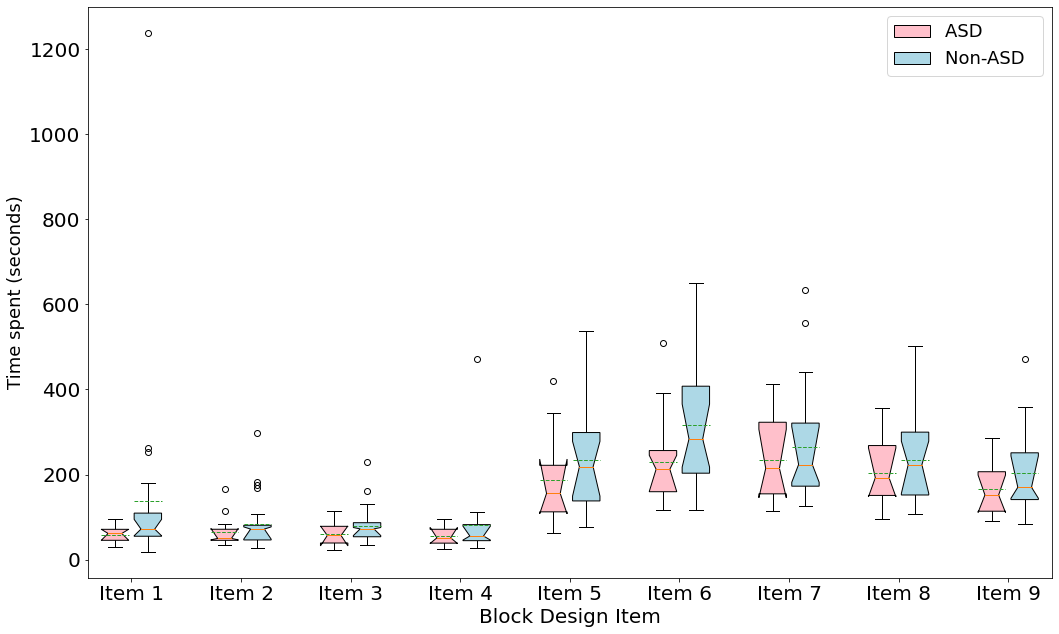

In [25]:
box(key="_time_spent", title="Time spent (seconds)", fname='time_spent.png')

['5c4684826a7dbc00017c0a87', '5c4e9bd1818d4d00013e8859', '5783d604900cc80001d2d767', '5a94ca1a873cda0001dc7147', '6104d2792c6a9b50dfbc4239', '578bcb2c09fb91000133750e', '5d1e2045a37a4d001a1fc2cb', '62cf1b74abd9894b74d28a00', '61692abb0f3acf7a49d91533', '62e1bc1f7bc99745a170ce2e', '628c2454c8c66010dd87391d', '55cb79e0fdf99b3c26ae4bca', '5b690c1840003400016fdb4b', '5eb3935fd0e02317909c5f32', '58ae45f35e63bf00013b530e']


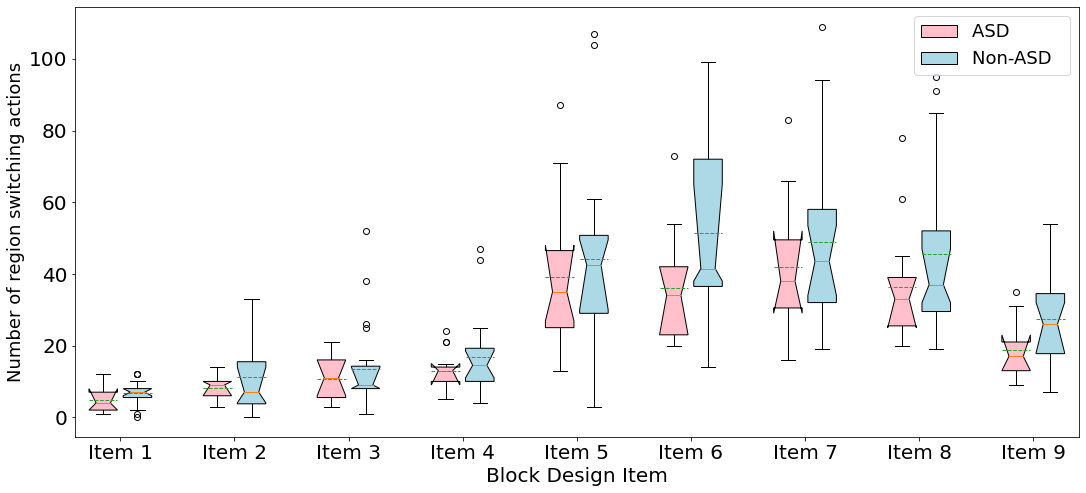

In [26]:
box(key="_pattern_show_events_num", title="Number of region switching actions", fname='regions.png')

In [27]:
def plot_scatter_all(key1, key2, key1_label=None, key2_label=None, fname=''):
    """Draw scatter plot"""

    key1_label = key1_label if key1_label is not None else key1
    key2_label = key2_label if key2_label is not None else key2

    DATA_PATH =  "/content/drive/MyDrive/AIVAS/Pilot Dec 1/pruned_valid_41data_feat.csv"
    to_excludePID = ['5ba5d8b960f3d50001697104', '5e5214e745774623bd28289f']

    #p1 = mpl.colormaps['Blues']
    csv_file = open(DATA_PATH, "r")
    csv_ = csv.DictReader(csv_file)
    csv_data = list(csv_)

    ASD_PID, NoNASD_PID = getPID_class()

    ### columns are named TASKID_key, i.e., 0_BlockRotation, 


    keys1 = [str(i) + key1 for i in range(9)]
    keys2 = [str(i) + key2 for i in range(9)]
    vals1_1 = []
    vals2_1 = []
    vals1_2 = []
    vals2_2 = []
    for row in csv_data:
        #if int(float(row['SC0'])) > THRESHOLD:
        if row['PROLIFIC_PID'] in to_excludePID:
            continue
        if (row['PROLIFIC_PID']) in ASD_PID:
          for i, k in enumerate(keys1):
                vals1_1.append(float(row[k]))
          for i, k in enumerate(keys2):
                vals1_2.append(float(row[k]))
        else:
            for i, k in enumerate(keys1):
                vals2_1.append(float(row[k]))
            for i, k in enumerate(keys2):
                vals2_2.append(float(row[k]))
    fig, ax = plt.subplots()
    
    plt.scatter(vals1_1, vals1_2, label='ASD (cc=' + str(np.corrcoef(vals1_1, vals1_2)[0, 1])[:4] + ')')
    plt.scatter(vals2_1, vals2_2, label='Non-ASD (cc=' + str(np.corrcoef(vals2_1, vals2_2)[0, 1])[:4] + ')')
    plt.title(key2_label + " versus " + key1_label)

    ax.set_ylabel(key2_label, fontsize=18)
    ax.set_xlabel(key1_label, fontsize=18)
    ax.legend(numpoints=1, loc='upper right')

    fig.tight_layout()
    fig.set_size_inches(10.5, 6.5)
    #fig.savefig("../images/" + fname, dpi=100, bbox_inches='tight')

['5c4684826a7dbc00017c0a87', '5c4e9bd1818d4d00013e8859', '5783d604900cc80001d2d767', '5a94ca1a873cda0001dc7147', '6104d2792c6a9b50dfbc4239', '578bcb2c09fb91000133750e', '5d1e2045a37a4d001a1fc2cb', '62cf1b74abd9894b74d28a00', '61692abb0f3acf7a49d91533', '62e1bc1f7bc99745a170ce2e', '628c2454c8c66010dd87391d', '55cb79e0fdf99b3c26ae4bca', '5b690c1840003400016fdb4b', '5eb3935fd0e02317909c5f32', '58ae45f35e63bf00013b530e']


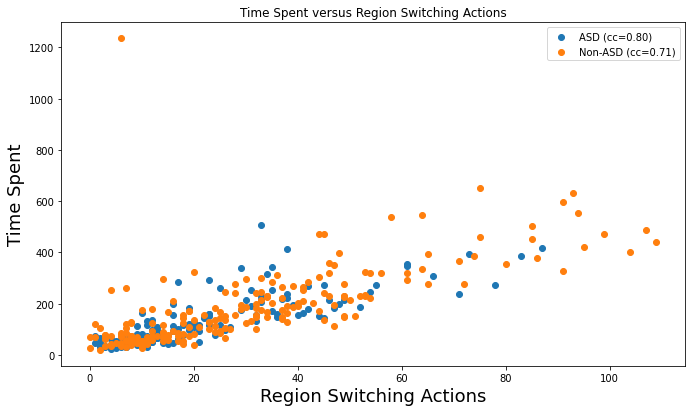

In [28]:
plot_scatter_all("_pattern_show_events_num", "_time_spent", key1_label="Region Switching Actions", key2_label="Time Spent")

['5c4684826a7dbc00017c0a87', '5c4e9bd1818d4d00013e8859', '5783d604900cc80001d2d767', '5a94ca1a873cda0001dc7147', '6104d2792c6a9b50dfbc4239', '578bcb2c09fb91000133750e', '5d1e2045a37a4d001a1fc2cb', '62cf1b74abd9894b74d28a00', '61692abb0f3acf7a49d91533', '62e1bc1f7bc99745a170ce2e', '628c2454c8c66010dd87391d', '55cb79e0fdf99b3c26ae4bca', '5b690c1840003400016fdb4b', '5eb3935fd0e02317909c5f32', '58ae45f35e63bf00013b530e']


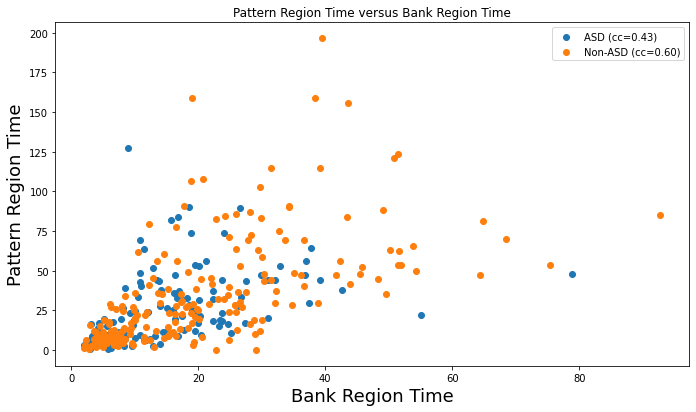

In [29]:
plot_scatter_all("_bank_region_time", "_pattern_region_time", key1_label="Bank Region Time", key2_label="Pattern Region Time")

['5c4684826a7dbc00017c0a87', '5c4e9bd1818d4d00013e8859', '5783d604900cc80001d2d767', '5a94ca1a873cda0001dc7147', '6104d2792c6a9b50dfbc4239', '578bcb2c09fb91000133750e', '5d1e2045a37a4d001a1fc2cb', '62cf1b74abd9894b74d28a00', '61692abb0f3acf7a49d91533', '62e1bc1f7bc99745a170ce2e', '628c2454c8c66010dd87391d', '55cb79e0fdf99b3c26ae4bca', '5b690c1840003400016fdb4b', '5eb3935fd0e02317909c5f32', '58ae45f35e63bf00013b530e']


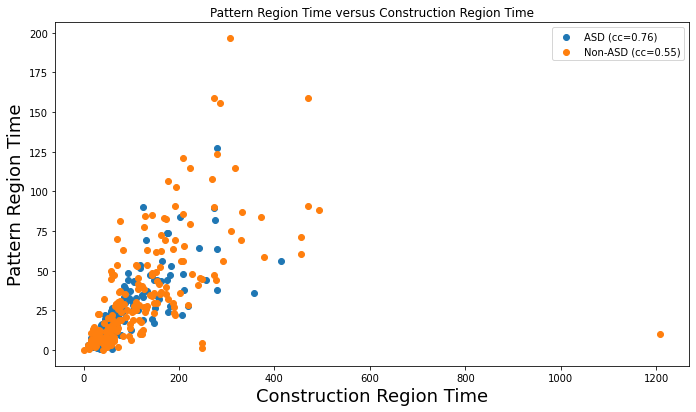

In [30]:
plot_scatter_all("_construction_region_time", "_pattern_region_time", key1_label="Construction Region Time", key2_label="Pattern Region Time")

In [42]:
def plot_scatter_all_multi(key1, key2, key1_label=None, key2_label=None, fname=''):
    """Draw scatter plot"""

    key1_label = key1_label if key1_label is not None else key1
    key2_label = key2_label if key2_label is not None else key2

    DATA_PATH =  "/content/drive/MyDrive/AIVAS/Pilot Dec 1/pruned_valid_41data_feat.csv"
    to_excludePID = ['5ba5d8b960f3d50001697104', '5e5214e745774623bd28289f']

    #p1 = mpl.colormaps['Blues']
    csv_file = open(DATA_PATH, "r")
    csv_ = csv.DictReader(csv_file)
    csv_data = list(csv_)

    ASD_PID, NoNASD_PID = getPID_class()

    ### columns are named TASKID_key, i.e., 0_BlockRotation, 

    keys1 = [str(i) + key1 for i in range(9)]
    keys2 = [str(i) + key2 for i in range(9)]
    vals1 = [[] for _ in range(9)]
    vals2 = [[] for _ in range(9)]
    for row in csv_data:
        if row['PROLIFIC_PID'] in to_excludePID:
            continue
        for i, k in enumerate(keys1):
            vals1[i].append(float(row[k]))
        for i, k in enumerate(keys2):
            vals2[i].append(float(row[k]))
    fig, ax = plt.subplots()
    
    for i in range(9):
        plt.scatter(vals1[i], vals2[i], label=str(i) + ', cc='+str(np.corrcoef(vals1[i], vals2[i])[0, 1])[:4])
    plt.title(key2_label + " versus " + key1_label)

    ax.set_ylabel(key2_label, fontsize=18)
    ax.set_xlabel(key1_label, fontsize=18)
    ax.legend(numpoints=1, loc='upper right')

    fig.tight_layout()
    fig.set_size_inches(10.5, 6.5)
    #fig.savefig("../images/" + fname, dpi=100, bbox_inches='tight')

['5c4684826a7dbc00017c0a87', '5c4e9bd1818d4d00013e8859', '5783d604900cc80001d2d767', '5a94ca1a873cda0001dc7147', '6104d2792c6a9b50dfbc4239', '578bcb2c09fb91000133750e', '5d1e2045a37a4d001a1fc2cb', '62cf1b74abd9894b74d28a00', '61692abb0f3acf7a49d91533', '62e1bc1f7bc99745a170ce2e', '628c2454c8c66010dd87391d', '55cb79e0fdf99b3c26ae4bca', '5b690c1840003400016fdb4b', '5eb3935fd0e02317909c5f32', '58ae45f35e63bf00013b530e']


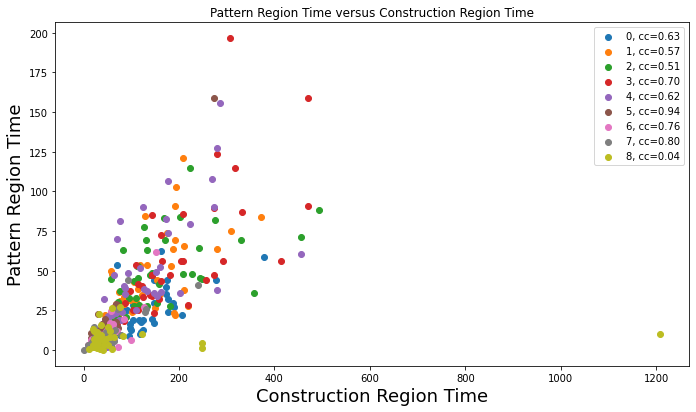

In [43]:
plot_scatter_all_multi("_construction_region_time", "_pattern_region_time", key1_label="Construction Region Time", key2_label="Pattern Region Time")

['5c4684826a7dbc00017c0a87', '5c4e9bd1818d4d00013e8859', '5783d604900cc80001d2d767', '5a94ca1a873cda0001dc7147', '6104d2792c6a9b50dfbc4239', '578bcb2c09fb91000133750e', '5d1e2045a37a4d001a1fc2cb', '62cf1b74abd9894b74d28a00', '61692abb0f3acf7a49d91533', '62e1bc1f7bc99745a170ce2e', '628c2454c8c66010dd87391d', '55cb79e0fdf99b3c26ae4bca', '5b690c1840003400016fdb4b', '5eb3935fd0e02317909c5f32', '58ae45f35e63bf00013b530e']


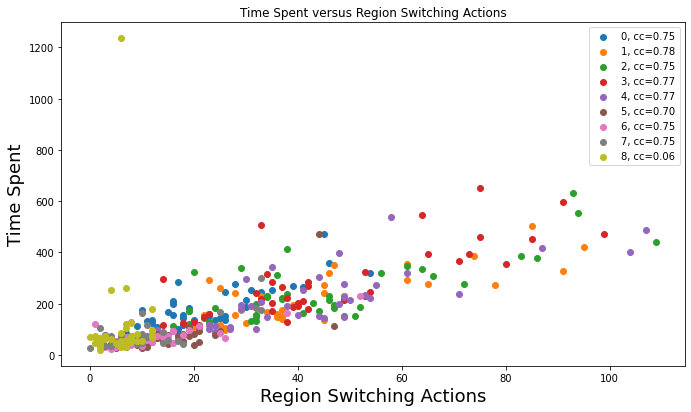

In [37]:
plot_scatter_all_multi("_pattern_show_events_num", "_time_spent", key1_label="Region Switching Actions", key2_label="Time Spent")